<a href="https://colab.research.google.com/github/helmana/DLeeg/blob/master/model%20layers%20pop/55%20instance_Threshold%20verification%20with%20Middle_TP-FN_TN-FP_FAR-FFR-EER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
'''
* verification with middle of data --- test threshold

subject number = 109 >> 90 train subject  + 19 new subject 
channel number = 20 >> [21,23,29,31,33,35,36,40,8,10,12,41,46,48,50,52,54,60,61,62]

model3 -  1 layer pop

'''


'\ncounter true and false verification\n\nsubject number = 109 >> 90 train subject  + 19 new subject \nchannel number = 20 >> [21,23,29,31,33,35,36,40,8,10,12,41,46,48,50,52,54,60,61,62]\n\nmodel3 -  1 layer pop\n\n'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install mne

     |████████████████████████████████| 6.4MB 2.7MB/s 


In [0]:
'''
Rivision:
980806:
  First version.
  
  

'''

'\nRivision:\n980806:\n  First version.\n  \n  \n\n'

In [0]:
# Parameters:

EpochNum=60
subject_numberT=109
RemoveBaseLine=0
Orthogonal=1
task_index = [1] # task: REO
list_channel=[21,23,29,31,33,35,36,40,8,10,12,41,46,48,50,52,54,60,61,62]
TryStr='Try1'
seed = 14

task_number=1
task_time = 60
sampel_number_per_sec =  160 # sampel rate
total_sampel_number =  sampel_number_per_sec *task_time # 60*160
#sample_shift = 4 #step len
inner_sample_shift = 4 # inner step len
outer_sample_shift =160  # outer step len
#sample_per_window = 160
window_len= 20
batch_size=64




In [4]:
# For Visualization
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

# General use
import itertools
from itertools import combinations 
import statistics
import csv
import os.path
from scipy.spatial import distance
import numpy as np
import math
import random
import datetime
import time
import pytz
from time import gmtime, strftime

# For model training
from keras import layers
from keras import models
from keras import regularizers
from keras.utils import to_categorical
from keras import optimizers
from keras import backend as KerasBackend
from keras.models import load_model



# EEG Tools
import mne
from mne.preprocessing import create_ecg_epochs, create_eog_epochs
from mne import io
from mne import viz
from mne import Epochs, io, pick_types
from mne.event import define_target_events
from mne.time_frequency import psd_welch
print(__doc__)



Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/numba/decorators.py:146: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)


Automatically created module for IPython interactive environment


In [5]:
# load dataset in array
task_number= len(task_index)

# load dataset in array
list_raw_fnames = [[0]*task_number]*subject_numberT
for x in range(subject_numberT):
  list_raw_fnames[x] = mne.datasets.eegbci.load_data(x+1,task_index,path='/content/drive/My Drive/Deep Results/Database')

list_rawdata = np.zeros((subject_numberT,task_number), dtype='object')

for i in range(subject_numberT):
  for j in range(task_number):
    list_rawdata[i][j] = mne.io.read_raw_edf(list_raw_fnames[i][j], preload=True)


Do you want to set the path:
    /content/drive/My Drive/Deep Results/Database
as the default EEGBCI dataset path in the mne-python config [y]/n? y
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/physiobank/database/eegmmidb/S002/S002R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/physiobank/database/eegmmidb/S003/S003R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.in

In [6]:
subject_number = 90
# new subject
new_subject =np.arange(subject_number, subject_numberT)

# img for each subject
subject_img_number = math.floor((total_sampel_number - sampel_number_per_sec - (window_len-1 )*inner_sample_shift) / outer_sample_shift) +1
np.random.seed(seed)  

subject_number_array_shuffled=np.arange(subject_number)
np.random.shuffle(subject_number_array_shuffled)

subject_img_number_array_shuffled=np.arange(subject_img_number)
np.random.shuffle(subject_img_number_array_shuffled)

train_index = len(subject_img_number_array_shuffled)//2
val_index = train_index + len(subject_img_number_array_shuffled)//4

train_shuff = subject_img_number_array_shuffled[:train_index]
val_shuff = subject_img_number_array_shuffled[train_index:val_index]
test_shuff = subject_img_number_array_shuffled[val_index:]


train_number = len(train_shuff)
val_number = len(val_shuff)
test_number = len(test_shuff)
print(train_number , val_number, test_number)
subject_img_number


29 14 16


59

In [0]:
def normalize_channel_data(ch , i, ch_min, ch_max):
  ch = ((ch - ch_min[i]) / (ch_max[i] - ch_min[i] ))
  return ch

def ProjectionVector(VecA,VecB):
    Projeted_VecB_on_VecA=np.dot(VecA,VecB)/np.dot(VecA,VecA)*VecA
    return Projeted_VecB_on_VecA

In [0]:
#################################################################################################
## Define General Data Generator
def GenerateGeneralData(BatchSize,ListRawDataMain,SubjectArrayShuffled,ListChannel,RemoveBaseLineFlag,OrthogonalFlag,ImageArrayShuffled,WindowLen,OuterSampleShift,InnerSampleShift,SampelNumberPerSec):
    
    Iter=0
    #ch_number=len(ListChannel)
    
    
    ##########################################################
    # Pre-Proceesing On Raw Data
    ListRawDataTemp=ListRawDataMain.copy()
    
    DataAllChannelsRawPerSubject, times =(ListRawDataTemp[0][0][:64,:9600])

    DataChannelsRaw   =np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    DataChannelsNormal=np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    DataChannelsOrt   =np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    e= 0    
    for s in SubjectArrayShuffled:

        DataAllChannelsRawPerSubject, times =(ListRawDataTemp[s][0][:64,:9600])
        
        # Extrac Channel T9 or T10 as Baseline
        DataChannelT9Raw =DataAllChannelsRawPerSubject[43]# Ch T9 (42) or T10 (43)


        ch_max =[]
        ch_min =[]
        # Extract Selected Channels+ Remove Baseline+ Normailze
        
        for i in range(len(ListChannel)):
            DataChannelsRaw[e][i]=DataAllChannelsRawPerSubject[ListChannel[i]].copy() -DataChannelT9Raw*RemoveBaseLineFlag

            ch_max = np.append(ch_max, max(DataChannelsRaw[e][i])) # max for each cannel
            ch_min = np.append(ch_min, min(DataChannelsRaw[e][i])) # min for each cannel

            DataChannelsNormal[e][i]=normalize_channel_data(DataChannelsRaw[e][i].copy(), i, ch_min, ch_max)
        e = e+1

        # Orthogonal Channel
        #DataChannelsOrt[e][0]=DataChannelsNormal[e][0]
        #DataChannelsOrt[e][1]=DataChannelsNormal[e][1]-ProjectionVector(DataChannelsNormal[e][0].copy(),DataChannelsNormal[e][1].copy())*OrthogonalFlag
        
        
        
    ##########################################################
    # Generate Data for Network
    while True:

      for j in ImageArrayShuffled:
          r = 0
          for s in SubjectArrayShuffled:

              if Iter ==0:
                  TrainImage=np.zeros((BatchSize, ch_number, WindowLen, SampelNumberPerSec), dtype = float)
                  TrainLabel=np.zeros((BatchSize),dtype=int)

              for i in range(len(ListChannel)):
                  for z in range (WindowLen):
                      ExtractedData = DataChannelsNormal[r][i][0+j*OuterSampleShift + z*InnerSampleShift:SampelNumberPerSec+ j*OuterSampleShift + z*InnerSampleShift]
                      TrainImage[Iter][i][z] = ExtractedData.copy()# Data
              r=r+1

              TrainLabel[Iter] = s # label

              Iter=Iter+1
              #Count=Count+1
              if Iter==BatchSize:
                Iter=0
                #print('Count=',Count)
                TrainLabelClass=to_categorical(TrainLabel,subject_numberT)
                TI = np.moveaxis(TrainImage, 1, -1)
                yield TI, TrainLabelClass 

                

In [0]:
ch_number=len(list_channel)
list_rawdataTemp=list_rawdata.copy()


In [0]:
#model.save('/content/drive/My Drive/mymodels/model1.h5')

In [10]:
model = load_model('/content/drive/My Drive/mymodels/model2_2.h5')
model.summary()
model.pop()
model.summary()







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 20, 160, 64)       11584     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 80, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 78, 128)        73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 39, 128)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 2, 37, 256)        295168    
____________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [0]:
def subject_Predict_generator(batch_size, mymodel, subject_arr, img_arr ):
  sn = len(subject_arr)
  imgn = len(img_arr)
  pre_GenTestData=GenerateGeneralData(BatchSize=batch_size,
                                  ListRawDataMain=list_rawdataTemp.copy(),
                                  SubjectArrayShuffled= subject_arr,
                                  ListChannel=list_channel,
                                  RemoveBaseLineFlag=RemoveBaseLine,
                                  OrthogonalFlag=Orthogonal,
                                  WindowLen=window_len,
                                  OuterSampleShift=outer_sample_shift,
                                  InnerSampleShift=inner_sample_shift,
                                  SampelNumberPerSec=sampel_number_per_sec,
                                  ImageArrayShuffled= img_arr)

  pre_Subject = mymodel.predict_generator(pre_GenTestData,steps=np.ceil(imgn*sn/batch_size))
  return pre_Subject


In [0]:

path = "/content/drive/My Drive/zz-160-1000-middle_variance"

try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

Creation of the directory /content/drive/My Drive/zz-160-1000-middle_variance failed


In [0]:
### calculate the median and variance of sample median

def calc_mid_var(subject_instance_num, start_index_s1, end_index_s1 ,start_index_s2, end_index_s2 ):
  same_list_result = []
  diff_list_result = []

  Same_ResultFileName =str(subject_instance_num)+ "outer shift 160_ Same subject _middle_variance " + "S1(" + str(start_index_s1) + '-' + str(end_index_s1) + ')'+'.csv'
  Diff_ResultFileName = "outer shift 160_ Different subject _middle_variance " + "S1(" + str(start_index_s1) + '-' + str(end_index_s1) + ')' + "_S2("+ str(start_index_s2) + '-' + str(end_index_s2) + ')'+'.csv'

  for i in range(subject_instance_num):

    # same subject
    same_list_dist = []
    S1_rand = random.randint(start_index_s1, end_index_s1)
    pre_subject_img_number_array_shuffled=np.arange(subject_img_number)
    np.random.shuffle(pre_subject_img_number_array_shuffled)
    
    pre_S1_rand = subject_Predict_generator(64, model, [S1_rand], pre_subject_img_number_array_shuffled)
    
    for i in range(len(pre_S1_rand)-1):
      dist = distance.euclidean(pre_S1_rand[i] , pre_S1_rand[i+1]) 
      same_list_dist.append(dist)
    #variance   
    same_variance_dist = statistics.variance(same_list_dist) 
    #middle
    same_middle_dist = statistics.median_low(same_list_dist)
    same_list_result.append([S1_rand,S1_rand, same_middle_dist, same_variance_dist])


    #different
    diff_list_dist = []
    S2_rand = random.randint(start_index_s2, end_index_s2)
    while S2_rand == S1_rand:
          S2_rand = random.randint(start_index_s2, end_index_s2)
    pre_subject_img_number_array_shuffled=np.arange(subject_img_number)
    np.random.shuffle(pre_subject_img_number_array_shuffled)

    pre_S2_rand = subject_Predict_generator(64, model, [S2_rand], pre_subject_img_number_array_shuffled)
    
    for i in range(len(pre_S1_rand)):
      dist = distance.euclidean(pre_S1_rand[i] , pre_S2_rand[i]) 
      diff_list_dist.append(dist)
    #variance   
    diff_variance_dist = statistics.variance(diff_list_dist) 
    #middle
    diff_middle_dist = statistics.median_low(diff_list_dist)
    diff_list_result.append([S1_rand, S2_rand, diff_middle_dist, diff_variance_dist])

  ##save resulte
  # same subject file
  with open(path+Same_ResultFileName, 'w+') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                          quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerows(same_list_result)

  # different subject file
  with open(path+Diff_ResultFileName, 'w+') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                          quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerows(diff_list_result)

  return  same_list_result , diff_list_result




In [0]:
same_result, diff_result = calc_mid_var(1000,0,89,0,89)
print("Done")


Done


In [0]:
same_result, diff_result = calc_mid_var(1000, 90,108,90,108)
print("Done")


Done


In [0]:
same_result, diff_result = calc_mid_var(70, 0,88,90,108)
print("Done")


Done


In [0]:
same_result, diff_result = calc_mid_var(70, 0,108,0,108)
print("Done")

Done


In [0]:
### verification with middle of samples

def VerifySubject(batch_size,threshold, s1, smp1, s2, smp2):
  list_d =[]
  vec1 = subject_Predict_generator(batch_size,model, [s1], smp1)
  vec2 = subject_Predict_generator(batch_size,model, [s2], smp2)
  for i in range(len(vec1)):
    d= distance.euclidean(vec1[i], vec2[i])
    list_d.append(d)
    midd = statistics.median_low(list_d)

  if (midd) <threshold :
    return 0 # same
  else:
    return 1 # different


In [13]:
path = "/content/drive/My Drive/z_Middle Verification Threshold_EER/55 instance"

try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)


list_threshold = []
list_TP = []
list_TN = []
list_FP = []
list_FN = []
list_FRR = []
list_FAR = []
list_EER = []
list_Correct_Verifi_Percentage = []
list_threshold_result =[]

### generate data for verification
def counter_true_false_result(start_index_s1, end_index_s1 ,start_index_s2, end_index_s2 ):
  
  threshold = 0
  pair_number = 2000
  sample_img_num = 55
  Batch_size = 55
  ITER = pair_number //2
  
  ## CSV file name 
  csvFileName =str(pair_number)+"pair"+ "_MIDDLE threshold_S1(" + str(start_index_s1)+ "-" + str(end_index_s1) + ")_S2("+ str(start_index_s2)+ "-" + str(end_index_s2) + ")" +".csv"
  completeName = os.path.join(path, csvFileName )

  png_FileName =str(pair_number)+"pair"+ "_MIDDLE threshold_S1(" + str(start_index_s1)+ "-" + str(end_index_s1) + ")_S2("+ str(start_index_s2)+ "-" + str(end_index_s2) + ")" +".png"
  png_completeName = os.path.join(path, png_FileName )

  for j in range(34,38):

      threshold = j*2
      TP =0
      TN =0
      FP =0
      FN =0
      FAR =0
      FRR =0
      EER =0
      true_result= 0
      false_result = 0
      Correct_Verifi_Percentage = 0

      for i in range(ITER):
        
          # subject 1 Genuine
          S1_rand = random.randint(start_index_s1, end_index_s1)
          # shuffled img indx array
          pre_S1_img_shuffled = np.arange(subject_img_number)
          np.random.shuffle(pre_S1_img_shuffled)

          # group sample 1
          S1_Sample_rand1 = pre_S1_img_shuffled[:sample_img_num]
          # group sample 2
          S1_Sample_rand2 = pre_S1_img_shuffled[sample_img_num : sample_img_num *2]

          # Genuine verify
          result1 = VerifySubject(Batch_size, threshold, S1_rand, S1_Sample_rand1, S1_rand, S1_Sample_rand2)
          
          if result1 == 0:
            true_result = true_result+1
            TP = TP +1 #TP
          else:
            false_result = false_result+1
            FN = FN +1

          # subject 2
          S2_rand = random.randint(start_index_s2, end_index_s2)
          while S2_rand == S1_rand:
            S2_rand = random.randint(start_index_s2, end_index_s2)

          # shuffled img indx array
          pre_S2_img_shuffled=np.arange(subject_img_number)
          np.random.shuffle(pre_S2_img_shuffled)
          # group sample
          S2_Sample_rand = pre_S2_img_shuffled[:sample_img_num]

          # Impostor vrify
          result2 = VerifySubject(Batch_size, threshold, S1_rand, S1_Sample_rand1, S2_rand, S2_Sample_rand)

          if result2 == 1:
            true_result = true_result+1
            TN = TN +1
          else: 
            false_result = false_result+1
            FP = FP +1
        
      #print(result1 , result2)
      Correct_Verifi_Percentage = (true_result *100) / (true_result + false_result)
      FAR = FP / (FP+TN)
      FRR = FN / (FN+TP)
      EER = (FAR+FRR) / 2

      list_threshold.append(threshold)
      list_TP.append(TP)
      list_TN.append(TN)
      list_FP.append(FP)
      list_FN.append(FN)
      list_FAR.append(FAR)
      list_FRR.append(FRR)
      list_EER.append(EER)
      list_Correct_Verifi_Percentage.append(Correct_Verifi_Percentage)
      ## print result
      print(threshold,'.', '\n', Correct_Verifi_Percentage,'%','\n',"true_result:",true_result,"false_result:",false_result,'\n',"TP:",TP,"FN:",FN,"FRR:",FRR ,'\n',"TN:",TN,"FP:",FP,"FAR:", FAR,'\n',"EER:",EER,'\n' )

  ##plot
  plt.plot(list_FRR, list_FAR  ) 
  plt.xlabel('FRR') 
  plt.ylabel('FAR') 
  plt.legend()
  plt.savefig(png_completeName) 


  list_threshold_result.append([(list_threshold[j], list_Correct_Verifi_Percentage[j], list_TP[j], list_FN[j], list_TN[j], list_FP[j], list_FAR[j], list_FRR[j] , list_EER[j] ) for j in range(len(list_Correct_Verifi_Percentage)) ])

  with open(completeName, 'w+') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                          quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerows(list_threshold_result[0])


Creation of the directory /content/drive/My Drive/z_Middle Verification Threshold_EER/55 instance failed


64 . 
 93.65 % 
 true_result: 1873 false_result: 127 
 TP: 886 FN: 114 FRR: 0.114 
 TN: 987 FP: 13 FAR: 0.013 
 EER: 0.0635 

66 . 
 93.9 % 
 true_result: 1878 false_result: 122 
 TP: 901 FN: 99 FRR: 0.099 
 TN: 977 FP: 23 FAR: 0.023 
 EER: 0.061 

68 . 
 93.95 % 
 true_result: 1879 false_result: 121 
 TP: 903 FN: 97 FRR: 0.097 
 TN: 976 FP: 24 FAR: 0.024 
 EER: 0.0605 

70 . 
 94.95 % 
 true_result: 1899 false_result: 101 
 TP: 937 FN: 63 FRR: 0.063 
 TN: 962 FP: 38 FAR: 0.038 
 EER: 0.0505 

72 . 
 94.55 % 
 true_result: 1891 false_result: 109 
 TP: 935 FN: 65 FRR: 0.065 
 TN: 956 FP: 44 FAR: 0.044 
 EER: 0.0545 

74 . 
 93.55 % 
 true_result: 1871 false_result: 129 
 TP: 953 FN: 47 FRR: 0.047 
 TN: 918 FP: 82 FAR: 0.082 
 EER: 0.0645 

76 . 
 93.75 % 
 true_result: 1875 false_result: 125 
 TP: 953 FN: 47 FRR: 0.047 
 TN: 922 FP: 78 FAR: 0.078 
 EER: 0.0625 



No handles with labels found to put in legend.


78 . 
 92.75 % 
 true_result: 1855 false_result: 145 
 TP: 962 FN: 38 FRR: 0.038 
 TN: 893 FP: 107 FAR: 0.107 
 EER: 0.0725 



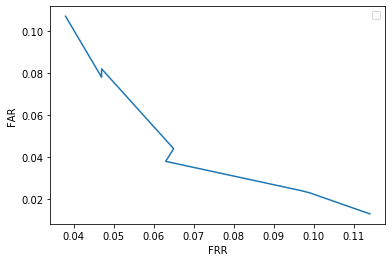

In [0]:
#1. train subject , train subject

counter_true_false_result(0,89, 0,89) 


In [0]:
#2. train subject , new subject

counter_true_false_result(0,89, 90,108)


64 . 
 91.65 % 
 true_result: 1833 false_result: 167 
 TP: 865 FN: 135 FRR: 0.135 
 TN: 968 FP: 32 FAR: 0.032 
 EER: 0.0835 

66 . 
 91.85 % 
 true_result: 1837 false_result: 163 
 TP: 885 FN: 115 FRR: 0.115 
 TN: 952 FP: 48 FAR: 0.048 
 EER: 0.0815 

68 . 
 93.9 % 
 true_result: 1878 false_result: 122 
 TP: 935 FN: 65 FRR: 0.065 
 TN: 943 FP: 57 FAR: 0.057 
 EER: 0.061 

70 . 
 92.1 % 
 true_result: 1842 false_result: 158 
 TP: 938 FN: 62 FRR: 0.062 
 TN: 904 FP: 96 FAR: 0.096 
 EER: 0.079 

72 . 
 91.1 % 
 true_result: 1822 false_result: 178 
 TP: 938 FN: 62 FRR: 0.062 
 TN: 884 FP: 116 FAR: 0.116 
 EER: 0.089 



KeyboardInterrupt: ignored

66 . 
 85.95 % 
 true_result: 1719 false_result: 281 
 TP: 768 FN: 232 FRR: 0.232 
 TN: 951 FP: 49 FAR: 0.049 
 EER: 0.1405 

68 . 
 86.35 % 
 true_result: 1727 false_result: 273 
 TP: 780 FN: 220 FRR: 0.22 
 TN: 947 FP: 53 FAR: 0.053 
 EER: 0.1365 

70 . 
 86.7 % 
 true_result: 1734 false_result: 266 
 TP: 809 FN: 191 FRR: 0.191 
 TN: 925 FP: 75 FAR: 0.075 
 EER: 0.133 

72 . 
 86.6 % 
 true_result: 1732 false_result: 268 
 TP: 833 FN: 167 FRR: 0.167 
 TN: 899 FP: 101 FAR: 0.101 
 EER: 0.134 



No handles with labels found to put in legend.


74 . 
 86.3 % 
 true_result: 1726 false_result: 274 
 TP: 859 FN: 141 FRR: 0.141 
 TN: 867 FP: 133 FAR: 0.133 
 EER: 0.137 



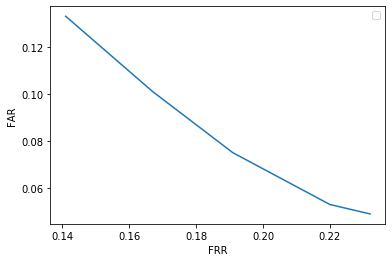

In [0]:
#3. new subject , new subject

counter_true_false_result(90,108, 0,89)

76 . 
 87.2 % 
 true_result: 1744 false_result: 256 
 TP: 901 FN: 99 FRR: 0.099 
 TN: 843 FP: 157 FAR: 0.157 
 EER: 0.128 



No handles with labels found to put in legend.


78 . 
 84.55 % 
 true_result: 1691 false_result: 309 
 TP: 902 FN: 98 FRR: 0.098 
 TN: 789 FP: 211 FAR: 0.211 
 EER: 0.1545 



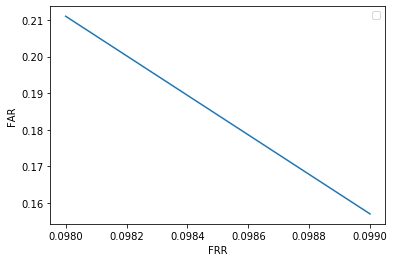

In [0]:
counter_true_false_result(90,108, 0,89)

68 . 
 82.5 % 
 true_result: 1650 false_result: 350 
 TP: 769 FN: 231 FRR: 0.231 
 TN: 881 FP: 119 FAR: 0.119 
 EER: 0.175 

70 . 
 84.15 % 
 true_result: 1683 false_result: 317 
 TP: 808 FN: 192 FRR: 0.192 
 TN: 875 FP: 125 FAR: 0.125 
 EER: 0.1585 

72 . 
 83.95 % 
 true_result: 1679 false_result: 321 
 TP: 863 FN: 137 FRR: 0.137 
 TN: 816 FP: 184 FAR: 0.184 
 EER: 0.1605 



No handles with labels found to put in legend.


74 . 
 79.65 % 
 true_result: 1593 false_result: 407 
 TP: 863 FN: 137 FRR: 0.137 
 TN: 730 FP: 270 FAR: 0.27 
 EER: 0.20350000000000001 



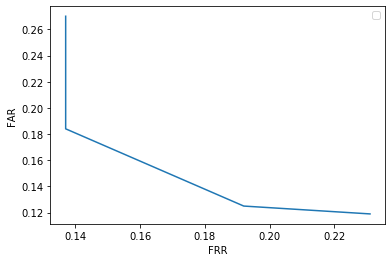

In [14]:
#4. new subject , new subject

counter_true_false_result(90,108, 90,108)


68 . 
 93.95 % 
 true_result: 1879 false_result: 121 
 TP: 911 FN: 89 FRR: 0.089 
 TN: 968 FP: 32 FAR: 0.032 
 EER: 0.0605 

70 . 
 93.2 % 
 true_result: 1864 false_result: 136 
 TP: 914 FN: 86 FRR: 0.086 
 TN: 950 FP: 50 FAR: 0.05 
 EER: 0.068 

72 . 
 92.0 % 
 true_result: 1840 false_result: 160 
 TP: 914 FN: 86 FRR: 0.086 
 TN: 926 FP: 74 FAR: 0.074 
 EER: 0.07999999999999999 



No handles with labels found to put in legend.


74 . 
 92.6 % 
 true_result: 1852 false_result: 148 
 TP: 942 FN: 58 FRR: 0.058 
 TN: 910 FP: 90 FAR: 0.09 
 EER: 0.074 



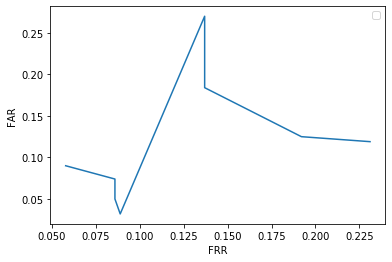

In [15]:
#5. all subject , all subject

counter_true_false_result(0,108, 0,108)
